# **Transformer Models**

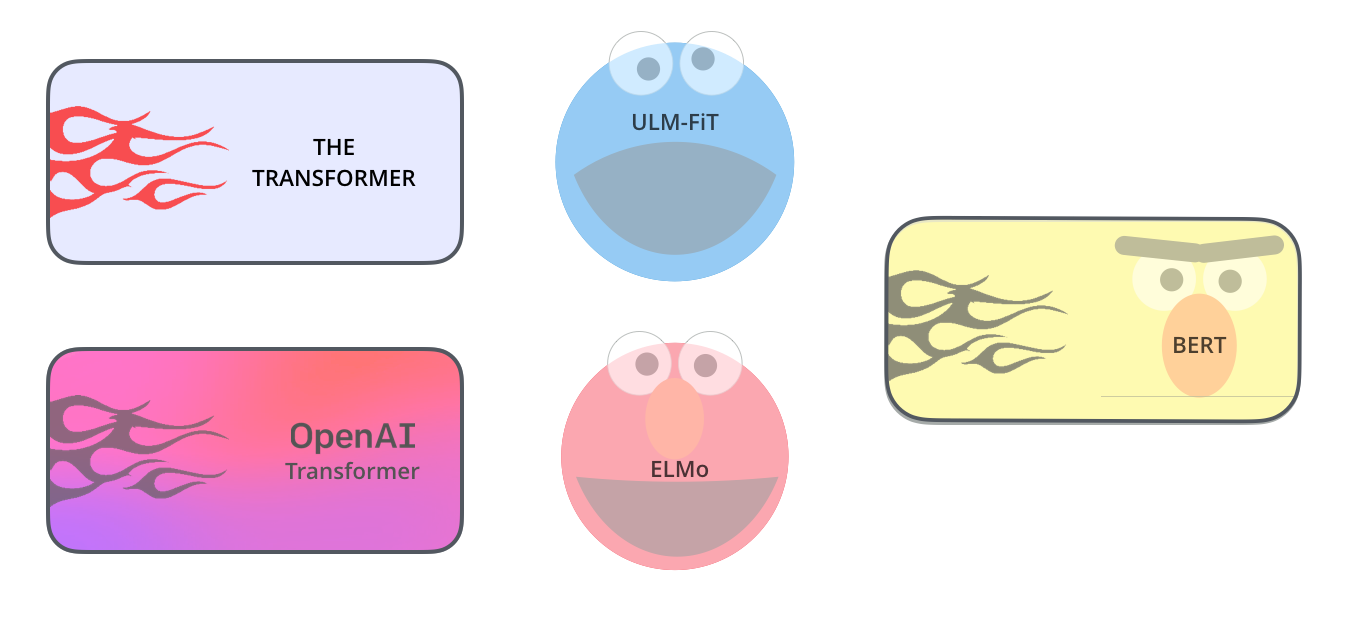







## Task Description

**Part 1**

Create something innovative using SBERT and semantic search, or even more! The guidelines are intentionally broad to encourage creativity. Here are some ideas to get you started:

*   Implement a GIF search engine or YouTube search function using images and CLIP.
*   (Optional) Use SetFit for supervised tasks with SBERT models.
*   Consider building a search engine using a Gradio or Streamlit app.

**Part 2**

*   **Gradient Descent Exercise:** Execute the process of updating weights for two examples using Stochastic Gradient Descent (SGD). Document each step, including input calculation, prediction, loss assessment, weight adjustments, and updates.

*   **Attention Mechanism Exercise:** Implement the attention mechanism on two distinct sentences. Choose sentences with polysmous words to demonstrate its functionality effectively.

**Delivery**

*   Create a dedicated GitHub repository for this assignment.
*   Store all relevant materials, including the Colab notebook, in the repository.
*   Provide a README.md file with a concise description of the assignment and its components.
*   You may work individually or in groups of up to three members.
*   Submit your work by emailing a link to the repository to Hamid (hamidb@business.aau.dk).

## Group members
* Benjamin Ly - 20205432
* Camilla Dyg Hannesbo - 20202923
* Tobias Moesgård Jensen - 20231658

## Part 1: SBERT and Semantic Search

### Setup and install

In [ ]:
!pip install pandas -U --q
!pip install sentence-transformers -U --q
!pip install tqdm -U --q
!pip install gradio -U --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 29.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.1 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.9/307.9 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import standard libraries
import pandas as pd  # Data manipulation and analysis
import gradio as gr  # Creating interactive web interfaces

from sentence_transformers import SentenceTransformer, util  # Sentence embeddings
from PIL import Image  # Image processing
import glob  # File path matching
import torch  # PyTorch deep learning framework
import pickle  # Python object serialization
import zipfile  # Zip file handling
from IPython.display import display  # Displaying HTML, images, etc.
from IPython.display import Image as IPImage  # Displaying images
import os  # Operating system interface
from tqdm.autonotebook import tqdm  # Progress bar
torch.set_num_threads(4)  # Set number of threads for PyTorch

# Other
from IPython.display import HTML  # Displaying HTML content
from IPython.core.interactiveshell import InteractiveShell  # Interactive shell configuration
InteractiveShell.ast_node_interactivity = "all"  # Display output for all expressions


In [ ]:
# Use wget to download the master.zip file which contains the dataset
!wget https://github.com/raingo/TGIF-Release/archive/master.zip -q

In [ ]:
# Unzip the master.zip file quietly (without progress)
# !unzip master.zip
!unzip -q master.zip

In [ ]:
# Importing the drive module from the google.colab library
from google.colab import drive

# Mount Google Drive to access files
drive.mount('/content/drive')

# Load dataset to a pandas dataframe
df = pd.read_csv(
    "./TGIF-Release-master/data/tgif-v1.0.tsv",  # Path to the TSV file
    delimiter="\t",  # Using tab (\t) as the delimiter
    names=['url', 'description']  # Naming the columns as 'url' and 'description'
)

# Display the first few rows of the dataframe
df.head()

Mounted at /content/drive


,url,description
0,https://38.media.tumblr.com/9f6c25cc350f12aa74...,"a man is glaring, and someone with sunglasses ..."
1,https://38.media.tumblr.com/9ead028ef62004ef6a...,a cat tries to catch a mouse on a tablet
2,https://38.media.tumblr.com/9f43dc410be85b1159...,a man dressed in red is dancing.
3,https://38.media.tumblr.com/9f659499c8754e40cf...,an animal comes close to another in the jungle
4,https://38.media.tumblr.com/9ed1c99afa7d714118...,a man in a hat adjusts his tie and makes a wei...


In [ ]:
# Get the length of the dataframe (number of rows)
len(df)

125782

In [ ]:
# Number of *unique* GIFs in the dataset
len(df["url"].unique())

102068

In [ ]:
# We will only use the first 20k datarows in the dataset
df = df.iloc[:20000]

In [ ]:
# Count the occurrences of each unique URL in the 'url' column and sort them in descending order
dupes = df['url'].value_counts().sort_values(ascending=False)

### Example from the database

In [ ]:
# Define the URL of the duplicate GIF
dupe_url = "https://33.media.tumblr.com/88235b43b48e9823eeb3e7890f3d46ef/tumblr_nkg5leY4e21sof15vo1_500.gif"

# Filter the dataframe to get rows with the specified URL
dupe_df = df[df['url'] == dupe_url]

# Iterate over the rows in the filtered dataframe
# Display the GIF and its corresponding description
for _, gif in dupe_df.iterrows():
    HTML(f"<img src={gif['url']} style='width:120px; height:90px'>")  # Display the GIF
    print(gif["description"])  # Print the description of the GIF


In [ ]:
# Iterate over rows 5 to 9 in the dataframe
for _, gif in df[5:10].iterrows():
    HTML(f"<img src={gif['url']} style='width:120px; height:90px'>")  # Display the GIF
    print(gif["description"])  # Print the description of the GIF

someone puts a cat on wrapping paper then wraps it up and puts on a bow


a brunette woman is looking at the man


a man on a bicycle is jumping over a fence.


a group of men are standing and staring in the same direction.


a man with black clothes is dancing sexy


### Building the model

In [ ]:
#First, we load the respective CLIP model
model = SentenceTransformer('clip-ViT-B-32')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
# Convert the 'description' column of the dataframe to a list
gif_description = df['description'].values.tolist()

In [ ]:
# Converting columns from the dataset to lists to be used as output in the semantic search function
url = df['url'].values.tolist()

In [ ]:
# Generate sentence embeddings for the list of GIF descriptions using the SentenceTransformer model
corpus_embeddings = model.encode(gif_description, convert_to_tensor=True)

#### Testing the model with a example

In the context of our search engine application, testing the model would involve verifying its ability to accurately retrieve relevant content based on user queries. We would assess metrics such as precision, recall, and accuracy to measure the effectiveness of the search functionality.

Additionally, creating a function to be integrated into a Gradio app allows us to deploy our model as an interactive web interface. This empowers users to input queries and receive search results in real-time, enhancing the usability and accessibility of our search engine. The Gradio app provides a user-friendly platform for users to interact with our model seamlessly, facilitating a smooth and intuitive user experience.

In [ ]:
# Creating 5 search examples to examine performance of the model
search_examples = ["someone puts a cat on wrapping paper then wraps it up and puts on a bow",
                    "a brunette woman is looking at the man",
                    "a man on a bicycle is jumping over a fence",
                    "a group of men are standing and staring in the same direction",
                    "a man with black clothes is dancing sexy"]

In [ ]:
# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = min(5, len(gif_description))
for query in search_examples:
    query_embedding = model.encode(query, convert_to_tensor=True)

    # We use cosine-similarity and torch.topk to find the highest 5 scores
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")

    for score, idx in zip(top_results[0], top_results[1]):
        print(gif_description[idx], "(Score: {:.4f})".format(score))





Query: someone puts a cat on wrapping paper then wraps it up and puts on a bow

Top 5 most similar sentences in corpus:
someone puts a cat on wrapping paper then wraps it up and puts on a bow (Score: 1.0000)
a cat is toying with a torn paper off a package. (Score: 0.7702)
a cat is batting at a wrapping paper tube. (Score: 0.7511)
a cat are ripping up and unrolling a roll of toilet paper. (Score: 0.7262)
a cat is biting and pulling at paper then it lies back (Score: 0.7262)




Query: a brunette woman is looking at the man

Top 5 most similar sentences in corpus:
a brunette woman is looking at the man (Score: 1.0000)
a woman is looking at a man. (Score: 0.9504)
it is a woman looking at a man really dramatically (Score: 0.9373)
a young woman is looking at a young man. (Score: 0.9327)
the man is looking up at the woman worried (Score: 0.9299)




Query: a man on a bicycle is jumping over a fence

Top 5 most similar sentences in corpus:
a man on a bicycle is jumping over a fence. (Scor

In [ ]:
# Defining the semantic search function to return gif url, description and cosinus score
def query_corpus(query):
  results = []
  query_embedding = model.encode(query, convert_to_tensor=True)
  cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
  top_results = torch.topk(cos_scores, k=top_k)

  for score, idx in zip(top_results[0], top_results[1]):
    results.append(
        (url[idx],
         gif_description[idx],
         score))
    Url = results[0][0]
    gif = f'<img src="{Url}" alt="gif" style="max-width: 200%;"/>'
    desc = "Description: " + results[0][1]
    score = "Cosinus Score: " + str(results[0][2].numpy())
  return gif, desc, score

In [ ]:
query_corpus('Man snowboarding')

('<img src="https://33.media.tumblr.com/46cdfaf7f736e4e084ca4868aa125079/tumblr_no90qlFKNA1uufz07o1_400.gif" alt="gif" style="max-width: 200%;"/>',
 'Description: someone jumps off a bump while snowboarding.',
 'Cosinus Score: 0.89771414')

### Gradio app for our search engine

With Gradio, we have build a interactive applications that enable users to interact with our search engine model through a web browser. For our search engine, we have leverage Gradio to create a simple yet powerful interface where users can input search queries and retrieve relevant results. By integrating our search functionality with Gradio, we provide users with an intuitive platform to explore and interact with our search engine, enhancing the user experience and making our search engine more accessible to a wider audience.

In [ ]:
# Create the interface
iface = gr.Interface(
    fn=query_corpus,
    inputs="text",
    outputs=["html", "text", "text"],
    title="🔍 Semantic Search",
    description="Enter your query to search for relevant content.",
    examples=[["Bunny eating fruits"]]
)

# Launch the interface
iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://4063b9cf88bb891246.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Part 2: Gradient Descent and Attention Mechanism Exercises

Part 2 of the group assigment consist of two questions:

* Gradient Descent Exercise: Execute the process of updating weights for two examples using Stochastic Gradient Descent (SGD). Document each step, including input calculation, prediction, loss assessment, weight adjustments, and updates.

* Attention Mechanism Exercise: Implement the attention mechanism on two distinct sentences. Choose sentences with polysmous words to demonstrate its functionality effectively.

### **Gradient Descent Exercise**

In [ ]:
# Setup and importing the libraries
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define the Examples and Initial Weights:

# Examples (features and target)
X = np.array([[1], [2], [3], [4], [5]])
y = np.array([2, 4, 6, 8, 10])

# Initial weights
weights = np.random.randn(1)
bias = np.random.randn(1)

In [ ]:
# Define the Prediction Function:

def predict(X, weights, bias):
    return np.dot(X, weights) + bias

In [ ]:
# Define the Loss Function (Mean Squared Error):

def calculate_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [ ]:
# Define the Gradient Calculation Function:

def calculate_gradients(X, y_true, y_pred):
    dw = np.mean(-2 * X * (y_true - y_pred))
    db = np.mean(-2 * (y_true - y_pred))
    return dw, db

In [ ]:
# Define the SGD Update Step:

def update_weights(weights, bias, dw, db, learning_rate):
    weights -= learning_rate * dw
    bias -= learning_rate * db
    return weights, bias

In [ ]:
# Execute SGD for Each Example:

learning_rate = 0.01
num_epochs = 100

loss_set = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i in range(len(X)):
        # Step 1: Prediction
        y_pred = predict(X[i], weights, bias)

        # Step 2: Loss assessment
        loss = calculate_loss(y[i], y_pred)
        epoch_loss += loss

        # Step 3: Gradient calculation
        dw, db = calculate_gradients(X[i], y[i], y_pred)

        # Step 4: Weight adjustments
        weights, bias = update_weights(weights, bias, dw, db, learning_rate)

    # Store average loss for this epoch
    epoch_loss /= len(X)
    loss_set.append(epoch_loss)

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')


Epoch 10/100, Loss: 0.0012601994741238897
Epoch 20/100, Loss: 0.0008783553471236203
Epoch 30/100, Loss: 0.0006122350192561181
Epoch 40/100, Loss: 0.0004267426845369165
Epoch 50/100, Loss: 0.00029745002013611185
Epoch 60/100, Loss: 0.00020732989148947723
Epoch 70/100, Loss: 0.00014451397207965755
Epoch 80/100, Loss: 0.00010072974994684192
Epoch 90/100, Loss: 7.021108324916538e-05
Epoch 100/100, Loss: 4.89388310168798e-05


Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Training Loss over Epochs')

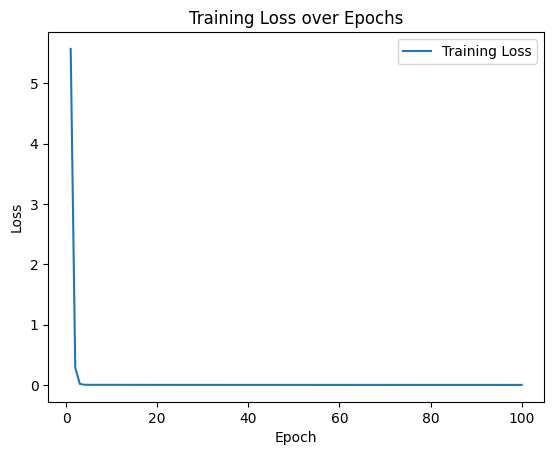

In [ ]:
# Plotting the training loss over epochs
plt.plot(range(1, num_epochs+1), loss_set, label='Training Loss')  # Plotting the training loss
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Loss')   # Label for the y-axis
plt.title('Training Loss over Epochs')  # Title of the plot
plt.legend()  # Display the legend
plt.show()   # Display the plot

### **Attention Mechanism Exercise**

In [ ]:
# Setup and importing the libraries
!pip install sentence_transformers --q
!pip install transformers --q

import torch
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertModel

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Load SBERT model
model_SBERT = SentenceTransformer('paraphrase-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Define the sentences
sentence1 = "She saw a bat flying in the night sky"
sentence2 = "He used a bat to hit the baseball during the game"

In [ ]:
# Compute sentence embeddings
embeddings = model_SBERT.encode([sentence1, sentence2])

In [ ]:
# Encode the sentences to get embeddings
embedding1 = model_SBERT.encode([sentence1])[0]
embedding2 = model_SBERT.encode([sentence2])[0]

In [ ]:
# Print the embeddings
print("Sentence 1:", sentence1)
print("Embedding shape:", embedding1.shape)
print("")

print("Sentence 2:", sentence2)
print("Embedding shape:", embedding2.shape)

Sentence 1: She saw a bat flying in the night sky
Embedding shape: (384,)

Sentence 2: He used a bat to hit the baseball during the game
Embedding shape: (384,)


In [ ]:
# Function to compute attention scores and context vector
def compute_attention(target_word, sentence):
    attention_scores = {}
    tokens = sentence.split()
    for token in tokens:
        score = np.dot(model_SBERT.encode([target_word, token])[0], model_SBERT.encode([token, target_word])[0])  # Cosine similarity
        attention_scores[token] = score

    # Softmax
    exp_scores = {k: np.exp(v) for k, v in attention_scores.items()}
    total_exp_score = sum(exp_scores.values())
    softmax_scores = {k: v / total_exp_score for k, v in exp_scores.items()}

    # Compute context vector
    context_vector = np.zeros_like(embeddings[0])
    for token, score in softmax_scores.items():
        context_vector += model_SBERT.encode([token])[0] * score
    return context_vector

In [ ]:
# Extract words from both sentences
words = sentence1.split() + sentence2.split()

# Remove duplicate words
words = list(set(words))

# Extract word vectors
word_vectors = [model_SBERT.encode([word])[0] for word in words]

# Extract the coordinates for 2D plotting (using the first two dimensions)
x_2d = [vector[0] for vector in word_vectors]
y_2d = [vector[1] for vector in word_vectors]

Text(0.31473613, 0.55097604, 'in')

Text(-0.5131655, 0.13823682, 'saw')

Text(-0.050079823, 0.8925123, 'the')

Text(0.28579637, 0.33935127, 'night')

Text(0.20572944, 0.5492683, 'to')

Text(0.17319012, 0.9741911, 'He')

Text(-0.025955789, -0.036314685, 'hit')

Text(0.37731242, 0.6093887, 'bat')

Text(0.15111095, 0.65986514, 'game')

Text(0.41344106, 0.38177574, 'flying')

Text(-0.31575128, 0.7867629, 'a')

Text(-0.5495343, 0.4779966, 'used')

Text(0.47231904, 0.27436706, 'She')

Text(0.37012658, 0.98034525, 'baseball')

Text(0.18293245, 0.4996035, 'sky')

Text(0.06962752, 0.47804227, 'during')

Text(0.5, 0, 'Dimension 1')

Text(0, 0.5, 'Dimension 2')

Text(0.5, 1.0, '2D plot of word embeddings')

(-0.6006269887089729,
 0.5234117045998573,
 -0.08714768160134553,
 1.0311782458797096)

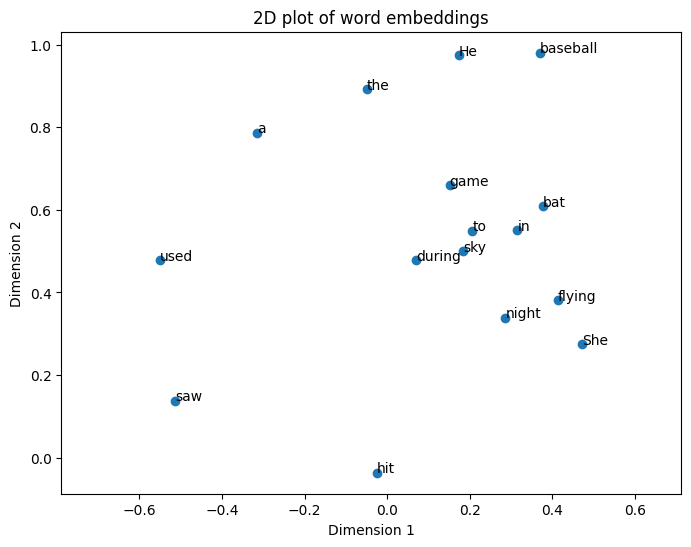

In [ ]:
# Create a 2D plot
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter the points
ax.scatter(x_2d, y_2d)

# Annotate the points with words
for i, word in enumerate(words):
    ax.text(x_2d[i], y_2d[i], word)

# Set labels
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title('2D plot of word embeddings')

# Set equal scaling
ax.axis('equal')

# Show the plot
plt.show()

In [ ]:
# Tokenize the sentences
tokens1 = sentence1.split()
tokens2 = sentence2.split()

# Encode the tokens to get embeddings
embeddings1 = model_SBERT.encode(tokens1)
embeddings2 = model_SBERT.encode(tokens2)

In [ ]:
# Assuming you already have the attention output for both sentences
# Let's create a dummy attention output for illustration
attention_output_1 = np.random.rand(len(tokens1), 2)
attention_output_2 = np.random.rand(len(tokens2), 2)

Text(0.5, 1.0, 'Original Word Embeddings for Sentence 2')

Text(0.5, 0, 'Dimension 1')

Text(0, 0.5, 'Dimension 2')

Text(0.5, 1.0, 'Self-Attention Output Vectors for Sentence 2')

Text(0.5, 0, 'Dimension 1')

Text(0, 0.5, 'Dimension 2')

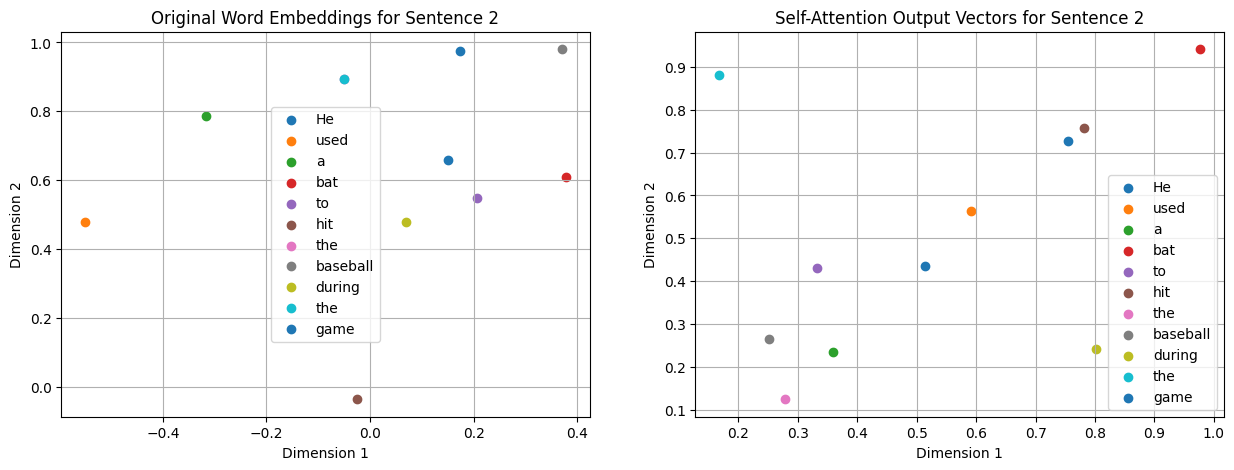

In [ ]:
# Set up the plot with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot original embeddings for sentence 1 on the left subplot
for i, word in enumerate(tokens2):
    axes[0].scatter(embeddings2[i, 0], embeddings2[i, 1], label=f"{word}")

axes[0].set_title('Original Word Embeddings for Sentence 2')  # Title for the left subplot
axes[0].set_xlabel('Dimension 1')  # Label for the x-axis
axes[0].set_ylabel('Dimension 2')  # Label for the y-axis
axes[0].grid(True)  # Enable grid for the left subplot
axes[0].legend()     # Display legend for the left subplot

# Plot output vectors for sentence 1 on the right subplot
for i, word in enumerate(tokens2):
    axes[1].scatter(attention_output_2[i, 0], attention_output_2[i, 1], label=f"{word}")

axes[1].set_title('Self-Attention Output Vectors for Sentence 2')  # Title for the right subplot
axes[1].set_xlabel('Dimension 1')  # Label for the x-axis
axes[1].set_ylabel('Dimension 2')  # Label for the y-axis
axes[1].grid(True)  # Enable grid for the right subplot
axes[1].legend()     # Display legend for the right subplot

plt.show()  # Display the plot


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_3 = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Encode text
text1 = "She saw a bat flying in the night sky"
text2 = "He used a bat to hit the baseball during the game"
inputs1 = tokenizer(text1, return_tensors="pt")
inputs2 = tokenizer(text2, return_tensors="pt")

# Get model output
with torch.no_grad():
    outputs1 = model_3(**inputs1)

# Get model output
with torch.no_grad():
    outputs2 = model_3(**inputs2)

In [ ]:
# Extract attentions
attentions1 = outputs1.attentions  # Tuple of 12 (one per layer) matrices of shape (batch_size, num_heads, sequence_length, sequence_length)
attentions2 = outputs2.attentions  # Tuple of 12 (one per layer) matrices of shape (batch_size, num_heads, sequence_length, sequence_length)

In [ ]:
# For simplicity, we'll use the attention weights from the first layer and the first head.
attention1 = attentions1[0][0, 0, :, :].detach().numpy()
attention2 = attentions2[0][0, 0, :, :].detach().numpy()

In [ ]:
# Tokenize the text to match tokens with attention weights
tokens1 = tokenizer.tokenize(tokenizer.decode(inputs1['input_ids'][0]))
tokens2 = tokenizer.tokenize(tokenizer.decode(inputs2['input_ids'][0]))

<ipython-input-46-d7ab3ce8089e>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + tokens2, rotation=90)  # Set x-axis labels with token names, rotated 90 degrees


[Text(-2.0, 1, ''),
 Text(0.0, 1, '[CLS]'),
 Text(2.0, 1, 'he'),
 Text(4.0, 1, 'used'),
 Text(6.0, 1, 'a'),
 Text(8.0, 1, 'bat'),
 Text(10.0, 1, 'to'),
 Text(12.0, 1, 'hit')]

<ipython-input-46-d7ab3ce8089e>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + tokens2)              # Set y-axis labels with token names


[Text(0, -2.0, ''),
 Text(0, 0.0, '[CLS]'),
 Text(0, 2.0, 'he'),
 Text(0, 4.0, 'used'),
 Text(0, 6.0, 'a'),
 Text(0, 8.0, 'bat'),
 Text(0, 10.0, 'to'),
 Text(0, 12.0, 'hit')]

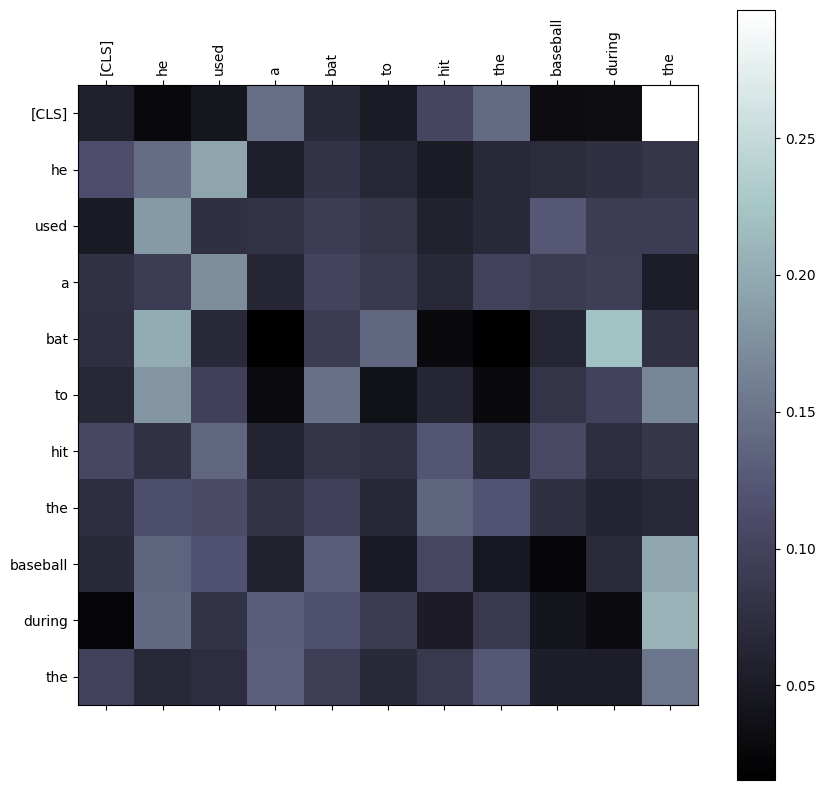

In [ ]:
# Visualizing the attention weights
fig, ax = plt.subplots(figsize=(10, 10))  # Create a subplot with a specified size
cax = ax.matshow(attention1, cmap='bone')  # Plot the attention weights as a matrix

# Add a colorbar to the plot
fig.colorbar(cax)

# Set up axes labels
ax.set_xticklabels([''] + tokens2, rotation=90)  # Set x-axis labels with token names, rotated 90 degrees
ax.set_yticklabels([''] + tokens2)              # Set y-axis labels with token names

# Show labels at every tick
ax.xaxis.set_major_locator(plt.MultipleLocator(1))  # Show labels at every tick on the x-axis
ax.yaxis.set_major_locator(plt.MultipleLocator(1))  # Show labels at every tick on the y-axis

# Display the plot
plt.show()

<ipython-input-47-3afd95cdd03e>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + tokens2, rotation=90)  # Set x-axis labels with token names, rotated 90 degrees


[Text(-2.0, 1, ''),
 Text(0.0, 1, '[CLS]'),
 Text(2.0, 1, 'he'),
 Text(4.0, 1, 'used'),
 Text(6.0, 1, 'a'),
 Text(8.0, 1, 'bat'),
 Text(10.0, 1, 'to'),
 Text(12.0, 1, 'hit'),
 Text(14.0, 1, 'the')]

<ipython-input-47-3afd95cdd03e>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + tokens2)              # Set y-axis labels with token names


[Text(0, -2.0, ''),
 Text(0, 0.0, '[CLS]'),
 Text(0, 2.0, 'he'),
 Text(0, 4.0, 'used'),
 Text(0, 6.0, 'a'),
 Text(0, 8.0, 'bat'),
 Text(0, 10.0, 'to'),
 Text(0, 12.0, 'hit'),
 Text(0, 14.0, 'the')]

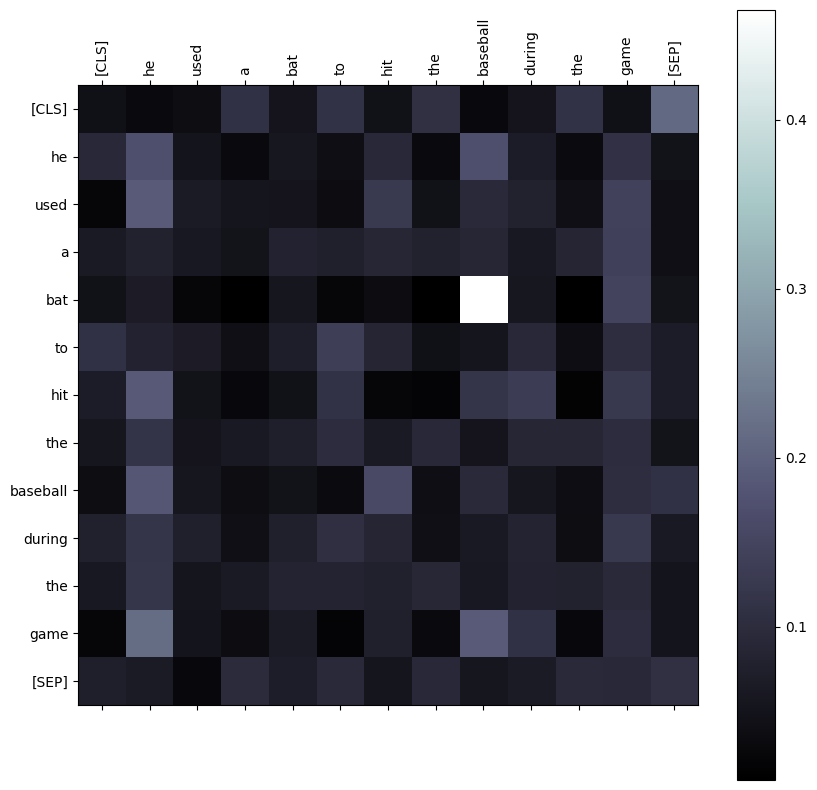

In [ ]:
# Visualizing the attention weights
fig, ax = plt.subplots(figsize=(10, 10))  # Create a subplot with a specified size
cax = ax.matshow(attention2, cmap='bone')  # Plot the attention weights as a matrix

# Add a colorbar to the plot
fig.colorbar(cax)

# Set up axes labels
ax.set_xticklabels([''] + tokens2, rotation=90)  # Set x-axis labels with token names, rotated 90 degrees
ax.set_yticklabels([''] + tokens2)              # Set y-axis labels with token names

# Show labels at every tick
ax.xaxis.set_major_locator(plt.MultipleLocator(1))  # Show labels at every tick on the x-axis
ax.yaxis.set_major_locator(plt.MultipleLocator(1))  # Show labels at every tick on the y-axis

# Display the plot
plt.show()

We see that the model finds a strong correlation between the words 'bat' and 'baseball' in sentence 2, where it struggles a bit more in sentence 1. Here the strongest corralations with the word 'bat' is in the words 'sky' and 'she'. So the model misunderstands the context a bit in sentence 1.